# Script for generating graphs for KAE EnKF Paper section 4.2: Latent state vs full state KAE EnKF

In [45]:
#Copy this script and then edit to make specific to your dataset for parameter tweaking
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
import seaborn as sb

#Set matplotlib settings as required
%matplotlib inline
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rcParams["figure.figsize"] = (12,8) # (w, h)
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import numpy as np
from scipy.sparse.linalg import svds
import cmath
from sklearn.preprocessing import PolynomialFeatures
import itertools
from scipy.stats import gaussian_kde

from libraries.KAE import KoopmanAE, KEDcoder, LinearKoopmanLayer, LuschLoss, gen_jordan_rotation_matrix
from libraries.DMDEnKF import EnKF
import simple_sin_helpers as ssf

### Show example synthetic data

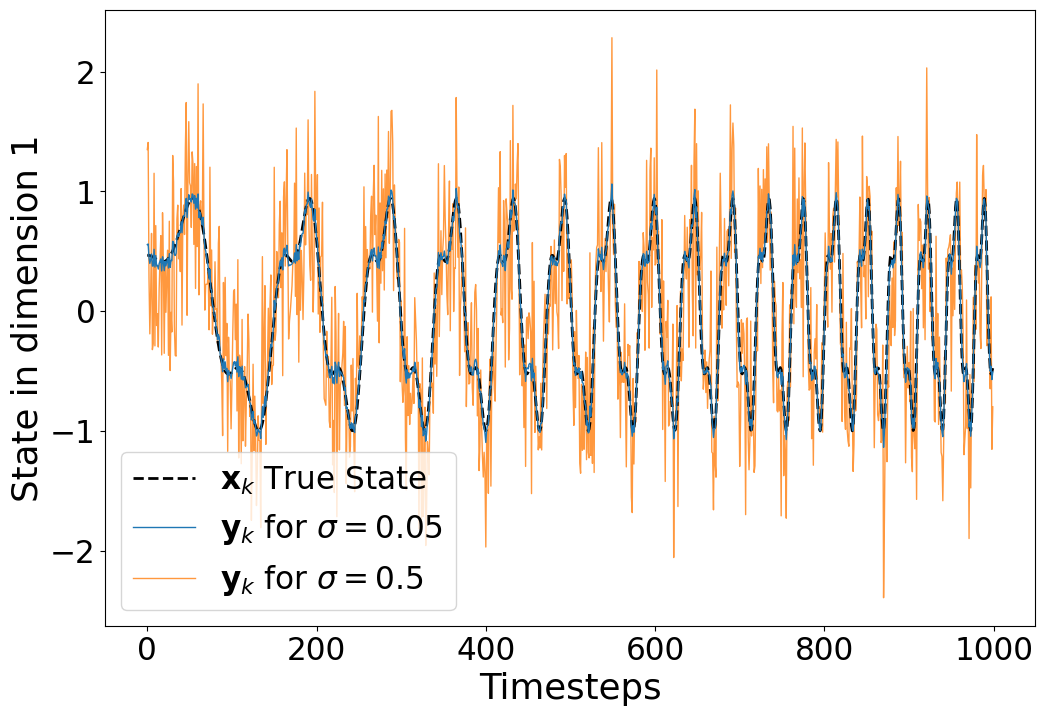

In [2]:
#example noise data plot

#data generation
num_data = 1000
num_spinup = 200
theta_start = np.pi/128
#theta_start = np.pi/32
#theta_end = np.pi/32
theta_end = np.pi/16
r_start = 1
r_end = 1
obs_cov = 0.05**2
data_dim = 100
power = 3

#Random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

#dataset and dataloaders
dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)

#do this again to ensure randomly generated measurment operator is the same for both (for graph purposes)
torch.manual_seed(0)
np.random.seed(0)
#dataset and dataloaders
highnoise_dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,0.5**2,data_dim,power)

plt.plot(dataset.true_highdim_data.T[0], label =r'$\mathbf{x}_k$ True State',alpha = 1, linewidth=2, ls='--',color='black',zorder=5)
plt.plot(dataset.data.T[0],alpha=1, color='tab:blue',zorder=10,label=r'$\mathbf{y}_k$ for $\sigma = 0.05$',linewidth=1)
plt.plot(highnoise_dataset.data.T[0],alpha=0.8,color='tab:orange', label=r'$\mathbf{y}_k$ for $\sigma = 0.5$',linewidth='1')
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.legend()
#plt.savefig('graphs/sin5_bothnoise_data_time_series.png',bbox_inches='tight')

### Run latent and full state KAE EnKF's over the data with 1000 ensemble points to enable more infirmative scatter plots

In [3]:
#Random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

#dataset and dataloaders
dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)


rank = 2
window_size = 10
system_cov_const = 0.05**2
obs_cov_const = obs_cov

eig_cov_const = 0.005**2

#standard setup, needed to be done before parameter tweaking to ensure all vars set correctly

#ALL PARAMETERS

#KAE variables
input_size = data_dim    #hardsin uses 100
num_frequencies = 1    #hard2sin uses 2
intermid_size = 10
encoder_module_list = nn.ModuleList([nn.Linear(input_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,num_frequencies*2)])
decoder_module_list = nn.ModuleList([nn.Linear(num_frequencies*2,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,input_size)])

#training
batch_size = 64
epochs = 100
global_fourier_interval = 10
print_interval = 10


#dataset and dataloaders
train_dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)

#No validation set for this example
#val_dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)
#val_dataloader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dataloader = None

#initialise Koopman AE, loss function and optimiser and attatch them to the KAE class
kae = KoopmanAE(input_size,num_frequencies,encoder_module_list,decoder_module_list)
lossfunc = LuschLoss
#this is a variable used for setting weightings of loss function components (a1,a2,a3,a4,a5)
#standard, linear, reconstruction, amplitude stability, regularisation
loss_hyperparameters = [1,1,1,1,0.01]
opt = optim.AdamW(kae.parameters(),lr=0.01)
'''No svd init used in this example due to lower dimension of input data than layer size'''
U, _, _ = svds(np.array(dataset.spinup_data).T,k=intermid_size)
U = torch.from_numpy(U.astype(np.float32).copy())
kae.set_training_attributes(opt,lossfunc,loss_hyperparameters,train_dataloader,val_dataloader=val_dataloader,svd_init=None)

#Move to GPU (sadly needed to be done this way for JIT compiler compatibility)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
kae = kae.to(dev)
kae.device = dev
kae.linear_koopman_layer.device = dev

#TRAINING LOOP
kae.run_training_loop(epochs,global_fourier_interval=global_fourier_interval,print_interval=print_interval)

sys_cov_const = 0.05**2
param_cov_consts = np.array([0.0005**2,0.005**2])
obs_cov_const = obs_cov
init_cov_const = obs_cov_const

kaeenkf = ssf.apply_kae_enkf_filter(kae,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 1000)

kaeenkf2 = ssf.apply_fullstate_kae_enkf_filter(kae,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 1000)

p_step = 10
num_to_keep = num_data-num_spinup

#store predictions adjusted to same length, and aligned with data
kaeenkf_preds = np.vstack([ssf.kaeenkf_ensembles_p_step_pred(kae,ensemble,p_step)
                           for ensemble in kaeenkf.ensembles])[-num_to_keep:-p_step]

kaeenkf2_preds = np.vstack([ssf.kaeenkf_fullstate_ensembles_p_step_pred(kae,ensemble,p_step)
                           for ensemble in kaeenkf2.ensembles])[-num_to_keep:-p_step]

true_values = np.array(dataset.true_highdim_data[-(num_to_keep-p_step):])

0
tensor([1.])
tensor([0.6993])
Train Loss: 2.005962997674942
10
tensor([0.9998])
tensor([0.8087])
New Frequency: 4.417100238195215
Train Loss: 1.511702835559845
20
tensor([1.0003])
tensor([4.4020])
Train Loss: 1.540747195482254
New Frequency: 5.853356723874198
30
tensor([0.9975])
tensor([5.8360])
Train Loss: 1.579210788011551
New Frequency: 6.178349067349004
40
tensor([1.0011])
tensor([6.2912])
Train Loss: 0.9351866245269775
New Frequency: 0.04193449593223306
50
tensor([1.0028])
tensor([0.0196])
Train Loss: 0.37967802584171295
60
tensor([1.0007])
tensor([-0.0122])
Train Loss: 0.27394145354628563
New Frequency: 6.202810856642807
70
tensor([1.0006])
tensor([6.2540])
Train Loss: 0.24135655909776688
80
tensor([0.9986])
tensor([6.2167])
Train Loss: 0.23338357731699944
New Frequency: 6.19931631531512
90
tensor([1.0007])
tensor([6.2164])
Train Loss: 0.22228702530264854


### View ensemble members in latent space

<IPython.core.display.Javascript object>


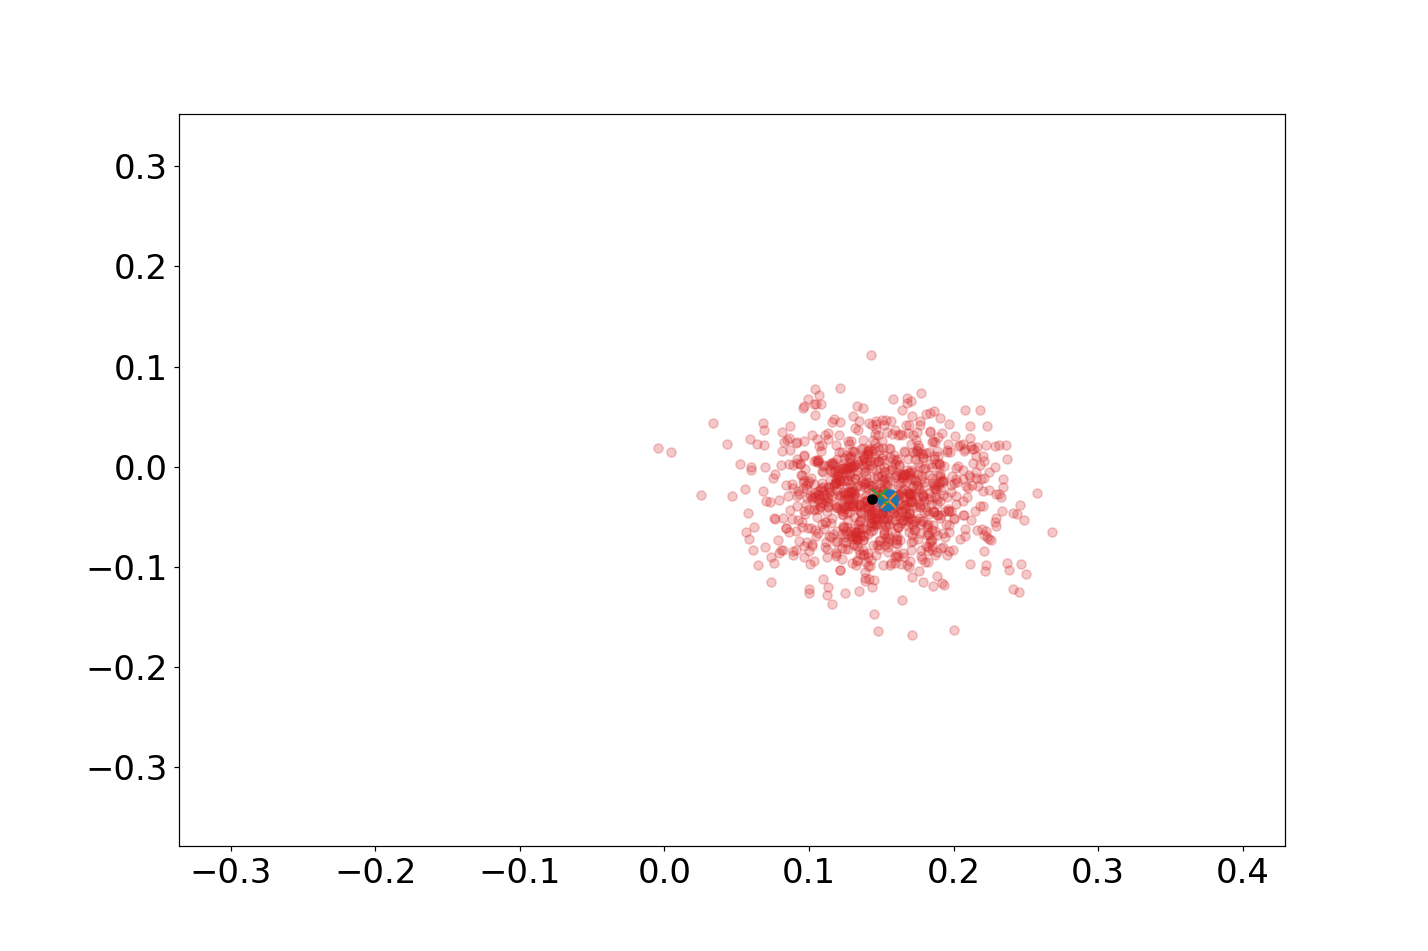

/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


In [30]:
'''from celluloid import Camera
%matplotlib notebook
fig = plt.figure()
camera = Camera(fig)

for i in range(num_to_keep):
    with torch.no_grad():
        enc_kaeenkf_ens = kae.encoder(torch.tensor(kaeenkf2.ensembles[i][:,:-2].astype(np.float32)))
    plt.scatter(enc_kaeenkf_ens.T[0].detach().numpy(),enc_kaeenkf_ens.T[1].detach().numpy(),color='tab:blue',alpha=0.25,zorder=5)
    enc_centroid = enc_kaeenkf_ens.detach().numpy().mean(axis=0)
    plt.scatter(enc_centroid[0],enc_centroid[1],color='tab:orange',marker='x',zorder=8,s=100)
    
    plt.scatter(kaeenkf.ensembles[i][:,:-2].T[0],kaeenkf.ensembles[i][:,:-2].T[1],color='tab:red',alpha=0.25)
    stand_centroid = kaeenkf.ensembles[i][:,:-2].mean(axis=0)
    plt.scatter(stand_centroid[0],stand_centroid[1],color='tab:green',marker='x',zorder=8,s=100)
    with torch.no_grad():
        plt.scatter(kae.encoder(dataset.true_highdim_data[num_spinup+ i])[0],kae.encoder(dataset.true_highdim_data[num_spinup + i])[1]
                    ,color='black',zorder=10)
        plt.plot(*np.vstack([enc_centroid,kae.encoder(dataset.true_highdim_data[num_spinup+ i])]).T,color='tab:blue',
                zorder=9)
        plt.plot(*np.vstack([stand_centroid,kae.encoder(dataset.true_highdim_data[num_spinup+ i])]).T,color='tab:red',
                zorder=9)
        
    camera.snap()
    
anim = camera.animate(interval=200)'''

### View each latent ensemble's spread via generalised covariance

In [163]:
def normy(array):
    return (array-min(array))/(max(array) - min(array))

all_enc_kaeenkf_ens = [kae.encoder(torch.tensor(kaeensos[:,:-2].astype(np.float32))) for kaeensos in kaeenkf2.ensembles]
enc_Ps = [np.cov(kaeensos.detach().numpy().T) for kaeensos in all_enc_kaeenkf_ens]

full_covs2 = [np.linalg.det(P[:-2,:-2]) for P in kaeenkf2.Ps][1:]
latent_covs = [np.linalg.det(P[:-2,:-2]) for P in kaeenkf.Ps][1:]
latent_covs2 = [np.linalg.det(P) for P in enc_Ps][1:]
ncovs = [normy(cov) for cov in [full_covs2, latent_covs, latent_covs2]]

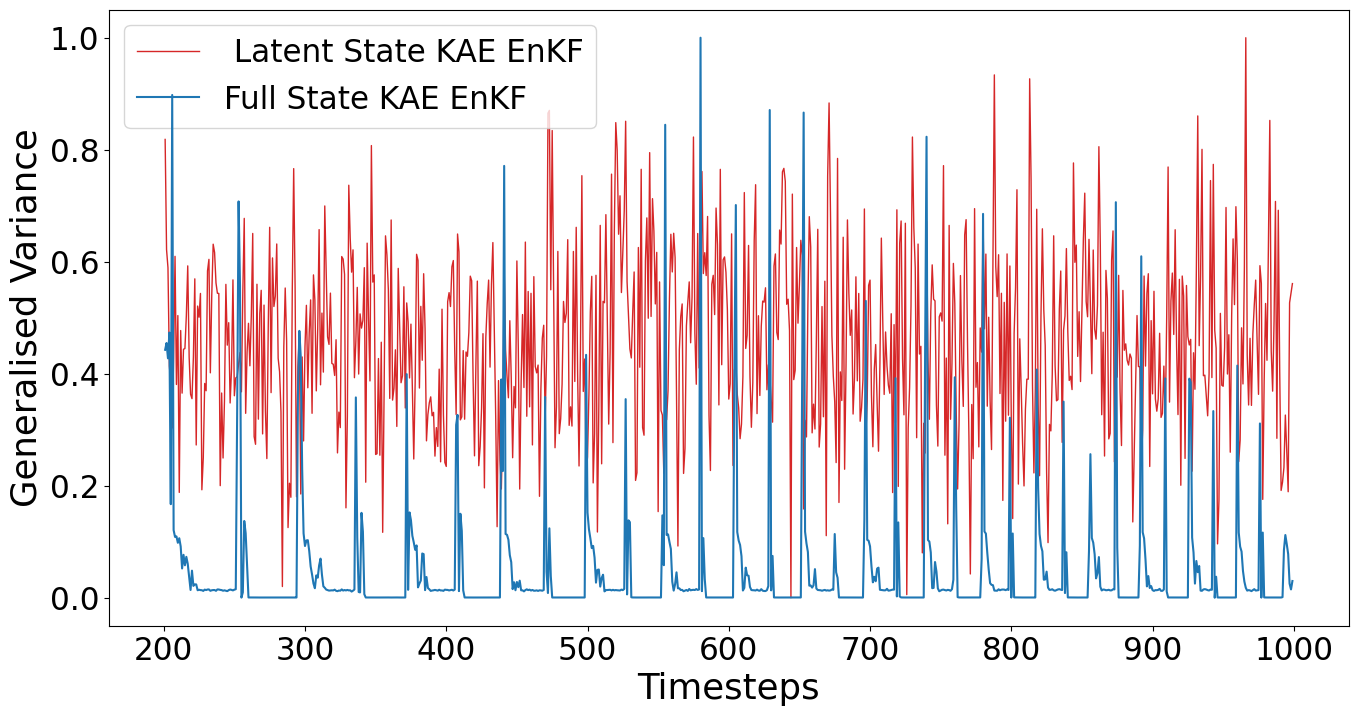

In [176]:
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
x = range(201,1000)


#plt.plot(x,np.ones(num_to_keep),label='True Eigenvalue',c='black',linewidth='2', ls='--',zorder=3)
#plt.plot(x,[x[-2] for x in kaeenkf.X][-num_to_keep:],label='Latent State KAE EnKF',c='tab:red',zorder=3)
#plt.plot(x,[x[-2] for x in kaeenkf2.X][-num_to_keep:],label='Ful State KAE EnKF',c='tab:blue',zorder=2)


plt.plot(x,ncovs[1],label=' Latent State KAE EnKF',c='tab:red',zorder=-1,linewidth=1)
plt.plot(x,ncovs[2],label='Full State KAE EnKF',c='tab:blue',zorder=10)

plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Generalised Variance')
plt.savefig('graphs/fullstate_kaeenkf_genvar_trajectory.png',bbox_inches='tight')

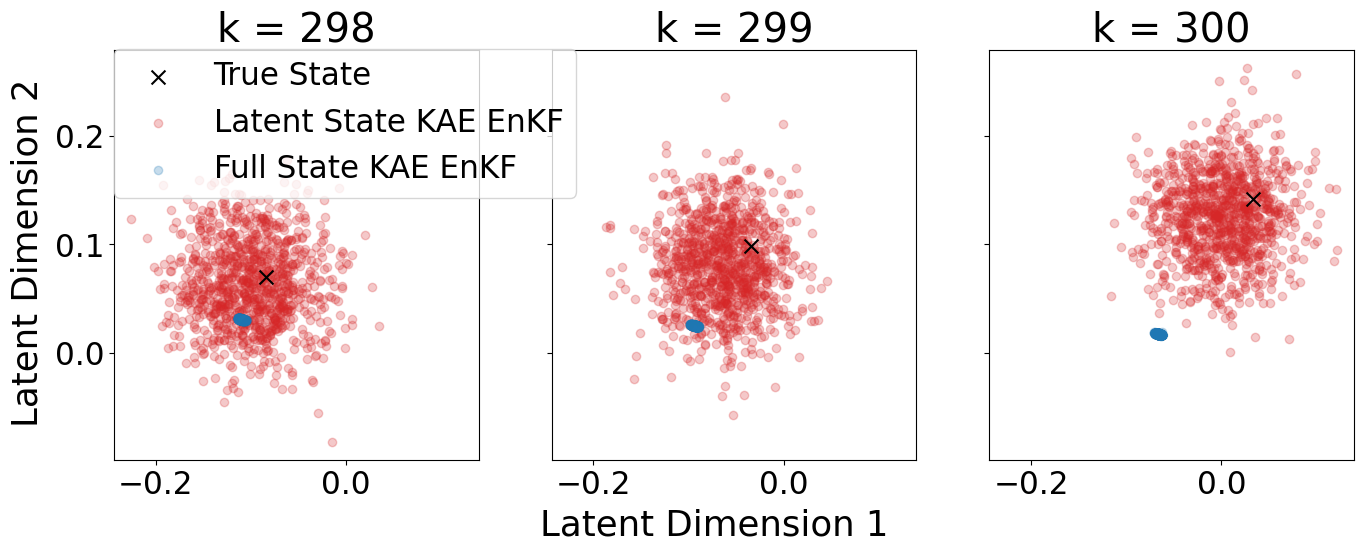

In [177]:
def nodecode_kaeenkf_ensemble_member_p_step_pred(kae,ensemble_member,p_step):
    amp = torch.tensor(ensemble_member[-kae.num_frequencies*2:-int(kae.num_frequencies)])
    freq = torch.tensor(ensemble_member[-kae.num_frequencies:])
    A = gen_jordan_rotation_matrix(amp, freq, p_step, kae.device)
    #apply dynamics to ensemble state
    new_ensemble_state = A@ensemble_member[:-kae.num_frequencies*2]
    return np.array(new_ensemble_state)

plt.rcParams["figure.figsize"] = (16,16/3) # (w, h)
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)

start_ind = 296
for j in range(3):
    cax = ax[j]
    plt.sca(cax)
    i = j + start_ind
    cax.set_title(f'k = {i+2}')
    
    with torch.no_grad():
        enc_kaeenkf_ens = kae.encoder(torch.tensor(kaeenkf2.ensembles[i][:,:-2].astype(np.float32)))

    with torch.no_grad():
        plt.scatter(kae.encoder(dataset.true_highdim_data[num_spinup+ i])[0],kae.encoder(dataset.true_highdim_data[num_spinup + i])[1]
                    ,color='black',marker='x', zorder=10,label='True State',s=100)
        
    plt.scatter(kaeenkf.ensembles[i][:,:-2].T[0],kaeenkf.ensembles[i][:,:-2].T[1]
            ,color='tab:red',alpha=0.25,label='Latent State KAE EnKF')
    
    plt.scatter(enc_kaeenkf_ens.T[0].detach().numpy(),enc_kaeenkf_ens.T[1].detach().numpy()
            ,color='tab:blue',alpha=0.25,zorder=5,label='Full State KAE EnKF')

#fig.supxlabel('common x label')
#fig.supylabel('common x label')
fig.text(0.5, -0.03, 'Latent Dimension 1', ha='center',size=MEDIUM_SIZE)
fig.text(0.06, 0.5, 'Latent Dimension 2', va='center', rotation='vertical',size=MEDIUM_SIZE)

plt.sca(ax[1])
plt.legend(loc=[-1.2,0.64])
#plt.savefig('graphs/fullstate_kaeenkf_ensemble1.png',bbox_inches='tight')

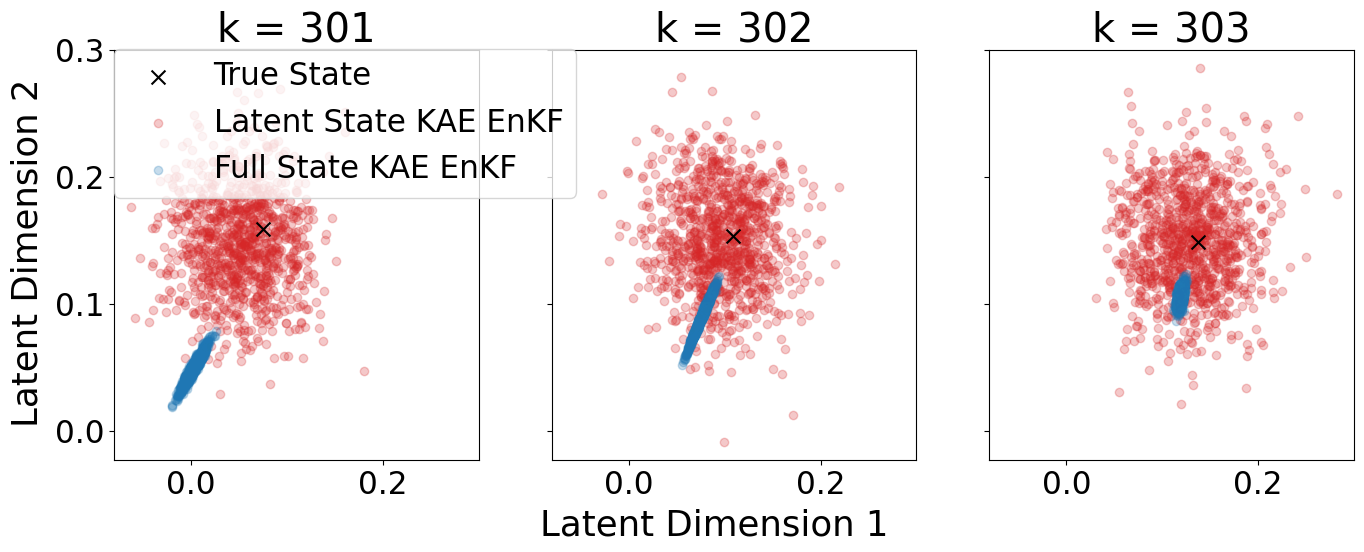

In [178]:

plt.rcParams["figure.figsize"] = (16,16/3) # (w, h)
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)

start_ind = 299
for j in range(3):
    cax = ax[j]
    plt.sca(cax)
    i = j + start_ind
    cax.set_title(f'k = {i+2}')
    
    with torch.no_grad():
        enc_kaeenkf_ens = kae.encoder(torch.tensor(kaeenkf2.ensembles[i][:,:-2].astype(np.float32)))

    with torch.no_grad():
        plt.scatter(kae.encoder(dataset.true_highdim_data[num_spinup+ i])[0],kae.encoder(dataset.true_highdim_data[num_spinup + i])[1]
                    ,color='black',marker='x', zorder=10,label='True State',s=100)
        
    plt.scatter(kaeenkf.ensembles[i][:,:-2].T[0],kaeenkf.ensembles[i][:,:-2].T[1]
            ,color='tab:red',alpha=0.25,label='Latent State KAE EnKF')
    
    plt.scatter(enc_kaeenkf_ens.T[0].detach().numpy(),enc_kaeenkf_ens.T[1].detach().numpy()
            ,color='tab:blue',alpha=0.25,zorder=5,label='Full State KAE EnKF')

#fig.supxlabel('common x label')
#fig.supylabel('common x label')
fig.text(0.5, -0.03, 'Latent Dimension 1', ha='center',size=MEDIUM_SIZE)
fig.text(0.06, 0.5, 'Latent Dimension 2', va='center', rotation='vertical',size=MEDIUM_SIZE)

plt.sca(ax[1])
plt.legend(loc=[-1.2,0.64])
plt.savefig('graphs/fullstate_kaeenkf_ensemble2.png',bbox_inches='tight')

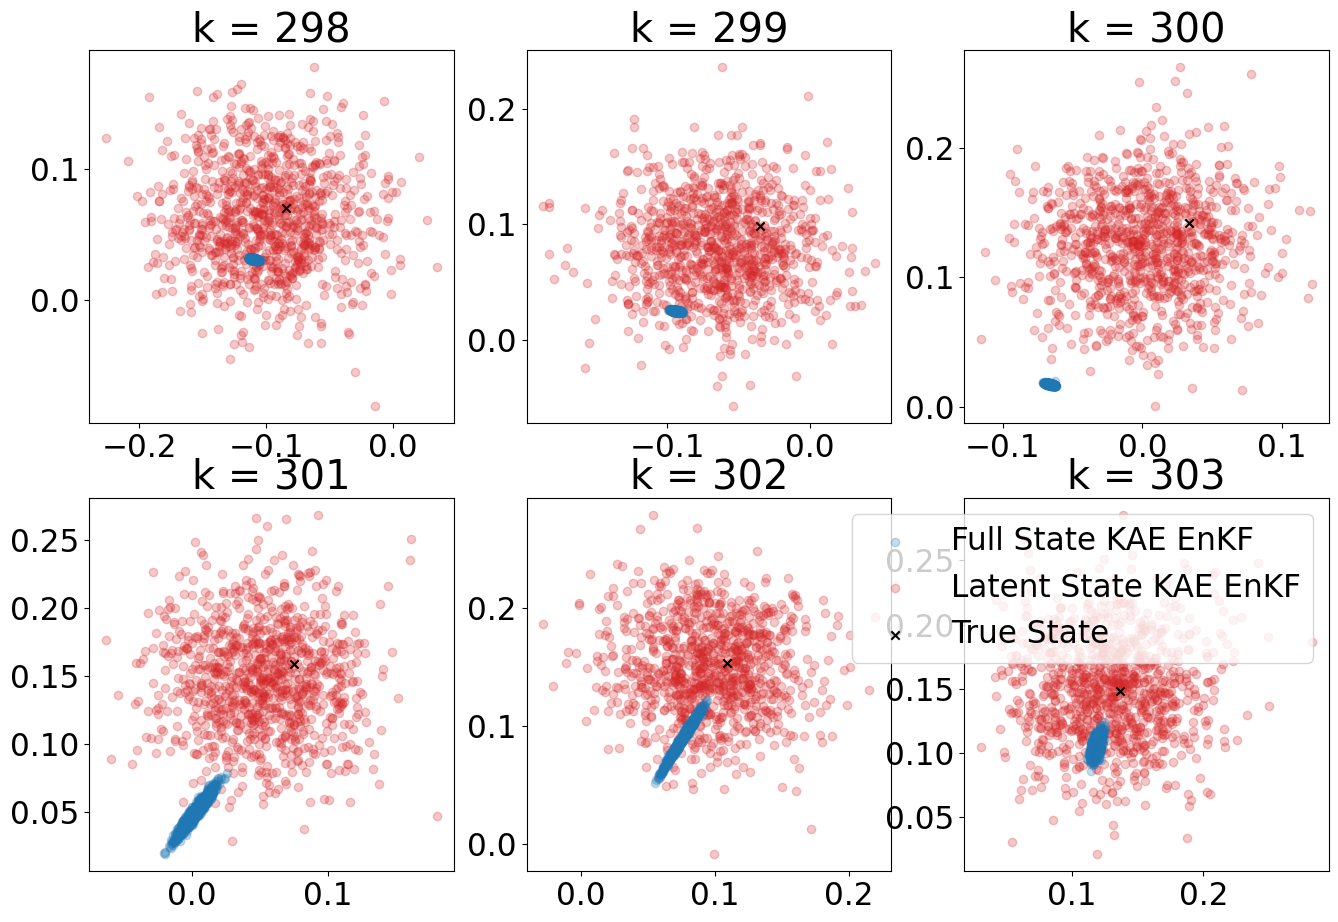

In [97]:

plt.rcParams["figure.figsize"] = (16,16*2/3) # (w, h)
fig,ax = plt.subplots(2,3)
start_ind = 296
for j in range(3):
    cax = ax[0][j]
    plt.sca(cax)
    i = j + start_ind
    
    with torch.no_grad():
        enc_kaeenkf_ens = kae.encoder(torch.tensor(kaeenkf2.ensembles[i][:,:-2].astype(np.float32)))
    plt.scatter(enc_kaeenkf_ens.T[0].detach().numpy(),enc_kaeenkf_ens.T[1].detach().numpy()
                ,color='tab:blue',alpha=0.25,zorder=5,label='Full State KAE EnKF')
    plt.scatter(kaeenkf.ensembles[i][:,:-2].T[0],kaeenkf.ensembles[i][:,:-2].T[1]
                ,color='tab:red',alpha=0.25,label='Latent State KAE EnKF')
    with torch.no_grad():
        plt.scatter(kae.encoder(dataset.true_highdim_data[num_spinup+ i])[0],kae.encoder(dataset.true_highdim_data[num_spinup + i])[1]
                    ,color='black',marker='x', zorder=10,label='True State')
        
    cax.set_title(f'k = {i+2}')
        
    cax = ax[1][j]
    plt.sca(cax)
    with torch.no_grad():
        enc_kaeenkf_ens = kae.encoder(torch.tensor(kaeenkf2.ensembles[i+3][:,:-2].astype(np.float32)))
    plt.scatter(enc_kaeenkf_ens.T[0].detach().numpy(),enc_kaeenkf_ens.T[1].detach().numpy()
                ,color='tab:blue',alpha=0.25,zorder=5,label='Full State KAE EnKF')
    plt.scatter(kaeenkf.ensembles[i+3][:,:-2].T[0],kaeenkf.ensembles[i+3][:,:-2].T[1]
                ,color='tab:red',alpha=0.25,label='Latent State KAE EnKF')
    with torch.no_grad():
        plt.scatter(kae.encoder(dataset.true_highdim_data[num_spinup+ i+3])[0],kae.encoder(dataset.true_highdim_data[num_spinup + i + 3])[1]
                    ,color='black',marker='x', zorder=10,label='True State')
        
    cax.set_title(f'k = {i+5}')
plt.legend()